**Описание задачи**

**Часть 1**

    1. Познакомиться с данными.
    2. Определить какой тип данных подойдет лучше для вашей задачи. Допускается предобработка данных на Python.
    3. Создать в базе данных таблицы и загрузить туда данные из соревнования с обязательной спецификацией типов.
    4. Связать таблицы согласно схемы во вложении.
    
    Результатом будет являться, наличие:

        1. Скриптов Python для предобработки данных, если потребовалось.
        2. Bash скрипты для спецификации и доставки данных в таблицы.

---

**Часть 2**

    1. Сгенерировать 5 гипотез на основе загруженных данных.
    2. Реализовать насчет признаков используя ТОЛЬКО SQL-запросы.

    Результатом будет являться, наличие:

        1. Текстового файла или .ipynb с 5ю гипотезами.
        2. Подготовленные SQL-запросы к базе данных в .ipynb, для насчета признаков.
        3. Наличие функции для отправки sql-запросов к БД.

---


## Часть 1

### Познакомиться с данными

In [1]:
import pandas as pd
from tqdm import tqdm

pd.options.display.max_columns = 150

Ознакомимся с ER-моделью данных.

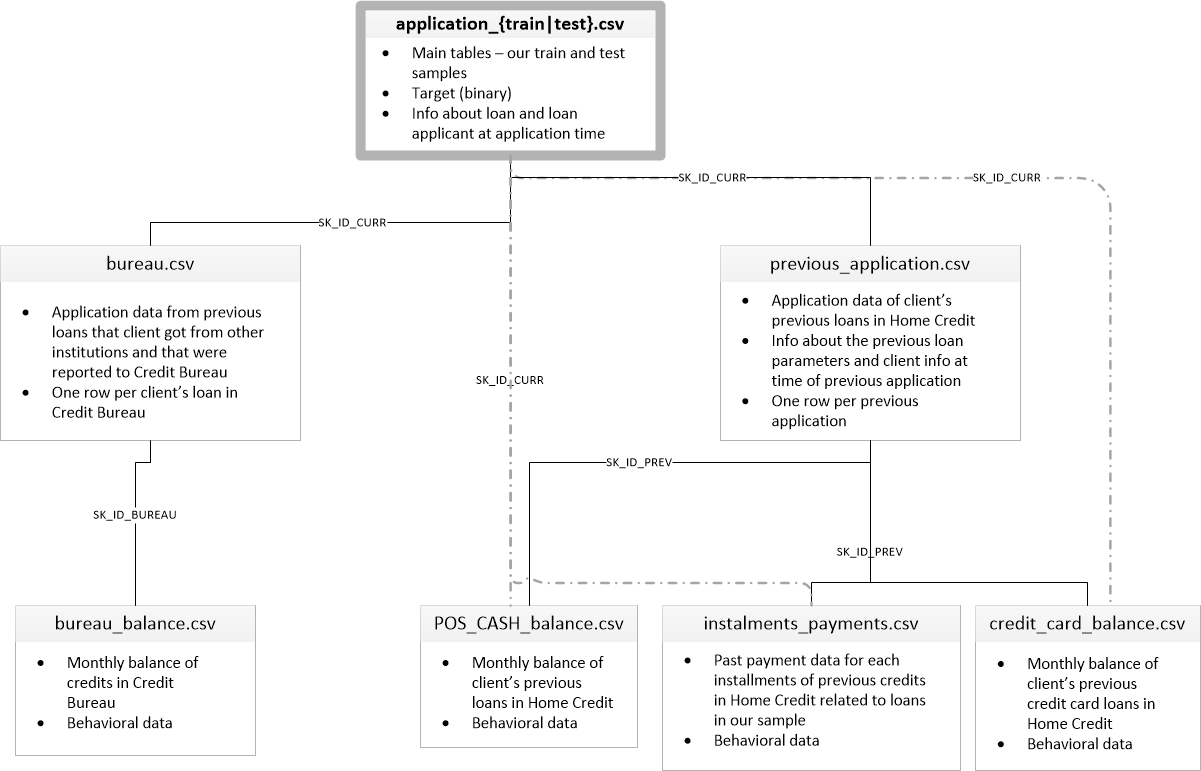

In [2]:
!ls ../../raw_data/

HomeCredit_columns_description.csv bureau_balance.csv
POS_CASH_balance.csv               credit_card_balance.csv
application_test.csv               installments_payments.csv
application_train.csv              previous_application.csv
application_united.csv             sample_submission.csv
bureau.csv


In [3]:
PATH = '/Users/Kirill/GitHub/cft-modelling/raw_data/'

Объединим трейн и тест датасеты для удобства.

In [4]:
# возьмем трейи и тест
train = pd.read_csv(PATH+'application_train.csv', engine='c')
test = pd.read_csv(PATH+'application_test.csv', engine='c')

# объединим в один датасет
df_united = pd.concat([train, test], ignore_index=True).sort_values(by='SK_ID_CURR')

# запишем в csv
df_united.to_csv(PATH+'application_united.csv', index=False)

In [5]:
def explore(file, isnull=False):
    '''
    Выводит первые 5 строк, инфо по датасету и инфо про уникальность ключей (PK|FK)
    ----------
    isnull=True: вывести таблицу с суммой пропусков по каждому признаку.
    '''
    print('\n'+file)
    df = pd.read_csv(PATH+file, engine='c', encoding='latin1')
    display(df.head(5))
    print()
    df.info(max_cols=125)
    print()
    if isnull:
        display(df.isna().sum())
        
    def uniq_check(series):
        if series.nunique() == series.shape[0]:
            status = 'ALL UNIQUE (PK)'
        else:
            status = 'not unique (FK)'
        return f'{series.name} values are {status}'
        
    for column in df.columns:
        if column in ['SK_ID_PREV', 'SK_ID_CURR', 'SK_ID_BUREAU']:
            print(uniq_check(df[column]))

In [6]:
def describe(feature_name):
    '''
    Находит в справочнике информацию о признаке по его названию.
    '''
    file = 'HomeCredit_columns_description.csv'
    df = pd.read_csv(PATH+file, engine='c', encoding='latin1')
    query = df.query('Row == @feature_name').Description.values.tolist()
    return query

In [7]:
# из вывода `!ls` создадим список файлой
files = !ls /Users/Kirill/GitHub/cft-modelling/raw_data/

# уберем train и test
files.remove('application_train.csv')
files.remove('application_test.csv')

# сделаем из получившегося списка итератор
files_iterator = iter(files)

In [8]:
explore(next(files_iterator))


HomeCredit_columns_description.csv


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB



* Содержит описание признаков

In [9]:
explore(next(files_iterator), isnull=True)


POS_CASH_balance.csv


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB



SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

SK_ID_PREV values are not unique (FK)
SK_ID_CURR values are not unique (FK)


* Monthly balance of client’s previous loans in Home Credit
* Behavioural data

In [10]:
explore(next(files_iterator))


application_united.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,NaN,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.985


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    356255 non-null  int64  
 1    TARGET                        307511 non-null  float64
 2    NAME_CONTRACT_TYPE            356255 non-null  object 
 3    CODE_GENDER                   356255 non-null  object 
 4    FLAG_OWN_CAR                  356255 non-null  object 
 5    FLAG_OWN_REALTY               356255 non-null  object 
 6    CNT_CHILDREN                  356255 non-null  int64  
 7    AMT_INCOME_TOTAL              356255 non-null  float64
 8    AMT_CREDIT                    356255 non-null  float64
 9    AMT_ANNUITY                   356219 non-null  float64
 10   AMT_GOODS_PRICE               355977 non-null  float64
 11   NAME_TYPE_SUITE               354052 non-null  object 
 12   NAME_INCOME_TYPE           

* Main tables – our train and test samples
* Target (binary)
* Info about loan and loan applicant at application time

In [11]:
explore(next(files_iterator), isnull=True)


bureau.csv


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB



SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

SK_ID_CURR values are not unique (FK)
SK_ID_BUREAU values are ALL UNIQUE (PK)


* Application data from previous loans that client got from other institutions and that were reported to Credit Bureau
* One row per client’s loan in Credit Bureau

In [12]:
explore(next(files_iterator), isnull=True)


bureau_balance.csv


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB



SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

SK_ID_BUREAU values are not unique (FK)


* Monthly balance of credits in Credit Bureau
* Behavioural data

In [13]:
explore(next(files_iterator), isnull=True)


credit_card_balance.csv


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATUR

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

SK_ID_PREV values are not unique (FK)
SK_ID_CURR values are not unique (FK)


* Monthly balance of client’s previous credit card loans in Home Credit
* Behavioural data

In [14]:
explore(next(files_iterator), isnull=True)


installments_payments.csv


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB



SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

SK_ID_PREV values are not unique (FK)
SK_ID_CURR values are not unique (FK)


* Past payment data for each installments of previous credits in Home Credit related to loans in our sample
* Behavioural data

In [15]:
explore(next(files_iterator))


previous_application.csv


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-n

* Application data of client’s previous loans in Home Credit
* Info about the previous loan parameters and client info at time of previous application
* One row per previous application

In [16]:
explore(next(files_iterator))


sample_submission.csv


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB

SK_ID_CURR values are ALL UNIQUE (PK)


**Вывод:**

* Парсер определил цифры в типы `int64, float64`, строки в тип `object`; можно настроить более экономичные типы;
* В некоторых признаках встречаются пропуски, их обработка потребует более глубоко погружения в данные;
* В ключах SK_ID_PREV, SK_ID_CURR и SK_ID_BUREAU пропусков нет, это PK и FK ключи;
* `HomeCredit_columns_description.csv` и `sample_submission.csv` нам не понадобятся, уберем их.

In [17]:
files.remove('HomeCredit_columns_description.csv')
files.remove('sample_submission.csv')

### Определить какой тип данных подойдет лучше для вашей задачи. Допускается предобработка данных на Python.

[Описание типов данных: PostgreSQL 14](https://www.postgresql.org/docs/14/datatype.html)

In [18]:
def return_type(series):
    '''
    Возвращает оптимальный для признака тип данных и информацию о наличии пропусков (NULL | NOT NULL)
    '''
    def get_type(dtype):
        # Если тип числовой
        if dtype == 'int64':
            if (series.min() >= -32768) & (series.max() <= 32767):
                return 'smallint'
            else:
                return 'integer'

        # Если тип с плавающей точкой
        if dtype == 'float64':
            return 'real'

        # Если тип смешанный или текстовый
        if dtype == 'object':
            length = series.str.len()
            num_uniq = length.nunique()
            len_max = int(length.max())

            if num_uniq == 1:
                return 'char(%s)' % len_max
            else:
                return 'varchar(%s)' % len_max

    def get_null_status(series):
        # Смотрит есть ли в сериии пропуски
        if series.isna().sum() == 0:
            return ' NOT NULL'
        else:
            return ' NULL'

    # Проверенные вручную PK и FK
    if series.name in ['SK_ID_PREV', 'SK_ID_CURR', 'SK_ID_BUREAU']:
        return 'integer NOT NULL'

    # Подбираем соответствующий тип SQL и NOT NULL|NULL
    series_type = get_type(series.dtype)
    null_status = get_null_status(series)
    
    return series_type + null_status

In [19]:
def return_types_dict(filepath):
    '''
    Возвращает словарь с именем файла, именами признаков и соответствующими типами данных.
    '''
    df = pd.read_csv(filepath, engine='c', encoding='latin1')
    
    result_dict = dict.fromkeys(df.columns)   
    
    for col in df.columns:
        result_dict[col] = return_type(df[col])
        
    return result_dict

**Исполнение первого скрипта: подготовка словаря**

In [20]:
# создадим словарь с ключами из имен рабочих файлов
sql_types = dict.fromkeys(files)

# заполним словарь признаками и их типами
for file in tqdm(files):
    sql_types[file] = return_types_dict(PATH+file)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:25<00:00, 12.16s/it]


### Создать в базе данных таблицы и загрузить туда данные из соревнования с обязательной спецификацией типов.

In [21]:
def script_sql(filename, data_source, script_output):
    '''
    Записывает sql-запросы для создания и наполнения базы данных home_credit
    '''
    fn_lower = filename.split('.')[0].lower()
    
    create = f"CREATE TABLE {fn_lower} (\n"
    copy = f"COPY {fn_lower} (\n"

    for column, data_type in sql_types[filename].items():
        create += f"  {column} {data_type},\n"
        copy += f"  {column},\n"

    create = create[:-2] + ");\n\n"
    copy = copy[:-2] + f")\nFROM '{data_source+filename}' DELIMITER ',' CSV HEADER;\n\n"

    with open(script_output+'create.sql', 'a') as file_:
        file_.write(create)

    with open(script_output+'copy.sql', 'a') as file_:
        file_.write(copy)

**Исполнение второго скрипта: запись словаря в sql-файлы**

In [22]:
data_source = '/Users/Kirill/GitHub/cft-modelling/raw_data/'
script_output = '/Users/Kirill/GitHub/cft-modelling/notebooks/hw_sql/'

# запишем скрипты 
for file in files:
    script_sql(file, data_source, script_output)

**Исполнение третьего скрипта: `home_credit_init.sh`**

```shell
export PATH=/Library/PostgreSQL/14/bin:$PATH

echo All tables in home_credit will be dropped. Enter password to continue:
sudo -u postgres psql -f /Users/Kirill/GitHub/cft-modelling/notebooks/hw_sql/drop.sql home_credit

echo 7 tables in home_credit will be created. Enter password to continue:
sudo -u postgres psql -f /Users/Kirill/GitHub/cft-modelling/notebooks/hw_sql/create.sql home_credit

echo Tables in home_credit will be populated from CSV. Enter password to continue:
sudo -u postgres psql -f /Users/Kirill/GitHub/cft-modelling/notebooks/hw_sql/copy.sql home_credit
```

### Связать таблицы согласно схемы во вложении.

Еще раз обратимся к ER-модели данных.

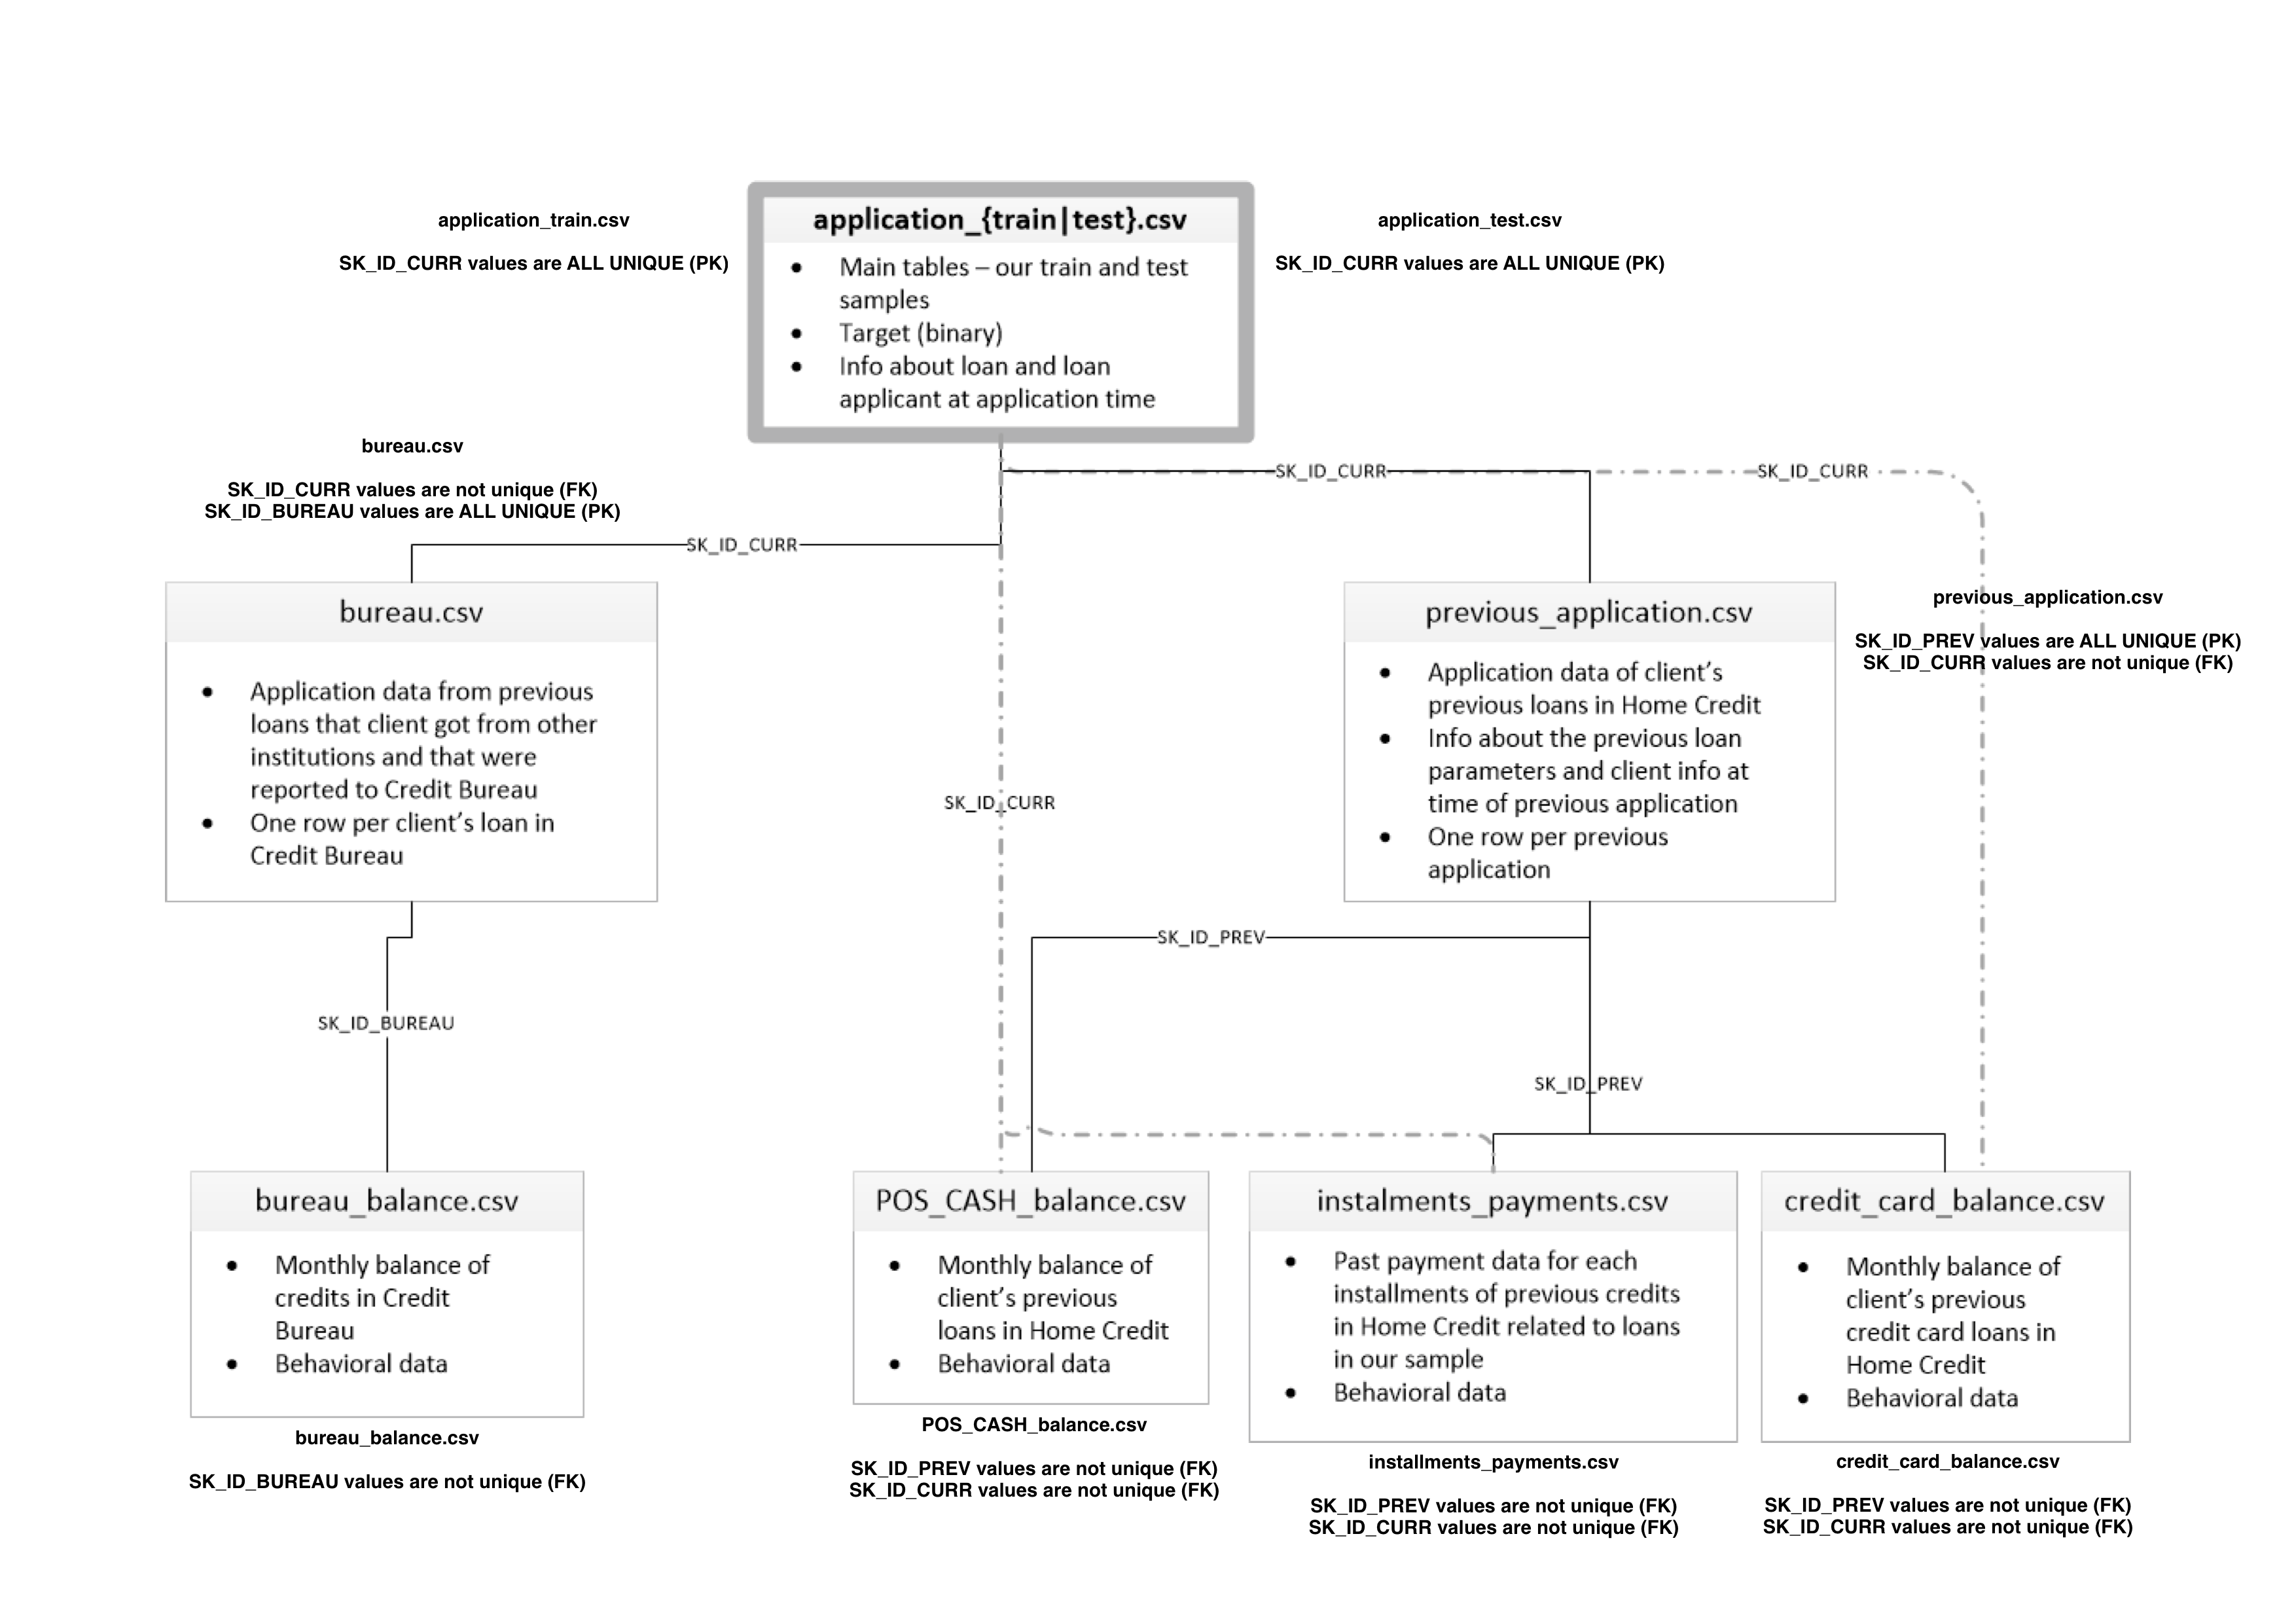

[Описание работы с psycopg2](https://eax.me/python-psycopg2/)

Напишем коннектор для выполнения команд и вывода запросов из базы данных.

In [23]:
import psycopg2


class Connector:

    def __init__(self):
        self.params = dict(dbname="home_credit",
                           user="reekuu",
                           password="reekuu",
                           host='127.0.0.1',
                           port=5432)

    def send(self, query):
        try:
            # connect to the PostgreSQL server & create a cursor
            print('Connecting to the PostgreSQL database...')
            conn = psycopg2.connect(**self.params)
            cur = conn.cursor()

            # execute a query & close the communication
            print('Executing query...')
            cur.execute(query)
            conn.commit()
            cur.close()            
            
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
            
        finally:
            if conn:
                conn.close()
                print('Database connection closed.')
                
    def read(self, query):
        conn = psycopg2.connect(**self.params)
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    

my_psql = Connector()

Добавим PRIMARY ключи.

In [24]:
query = '''
ALTER TABLE application_united ADD PRIMARY KEY (sk_id_curr);
ALTER TABLE bureau ADD PRIMARY KEY (sk_id_bureau);
ALTER TABLE previous_application ADD PRIMARY KEY (sk_id_prev);
'''
my_psql.send(query)

Connecting to the PostgreSQL database...
Executing query...
Database connection closed.


Добавим FOREIGN ключи.

In [25]:
query = '''
ALTER TABLE bureau ADD FOREIGN KEY (sk_id_curr) REFERENCES application_united(sk_id_curr);
ALTER TABLE previous_application ADD FOREIGN KEY (sk_id_curr) REFERENCES application_united(sk_id_curr);
ALTER TABLE pos_cash_balance ADD FOREIGN KEY (sk_id_curr) REFERENCES application_united(sk_id_curr);
ALTER TABLE installments_payments ADD FOREIGN KEY (sk_id_curr) REFERENCES application_united(sk_id_curr);
ALTER TABLE credit_card_balance ADD FOREIGN KEY (sk_id_curr) REFERENCES application_united(sk_id_curr);

ALTER TABLE pos_cash_balance ADD FOREIGN KEY (sk_id_curr) REFERENCES application_united(sk_id_curr);
ALTER TABLE installments_payments ADD FOREIGN KEY (sk_id_curr) REFERENCES application_united(sk_id_curr);
ALTER TABLE credit_card_balance ADD FOREIGN KEY (sk_id_curr) REFERENCES application_united(sk_id_curr);
'''
my_psql.send(query)

Connecting to the PostgreSQL database...
Executing query...
Database connection closed.


Связь между `bureau_balance` и `bureau` не удаётся устрановить из-за нарушенной целостности.

In [26]:
query = '''
ALTER TABLE bureau_balance ADD FOREIGN KEY (sk_id_bureau) REFERENCES bureau(sk_id_bureau);
'''
my_psql.send(query)

Connecting to the PostgreSQL database...
Executing query...
insert or update on table "bureau_balance" violates foreign key constraint "bureau_balance_sk_id_bureau_fkey"
DETAIL:  Key (sk_id_bureau)=(5717409) is not present in table "bureau".

Database connection closed.


## Часть 2

### Сгенерировать 5 гипотез на основе загруженных данных. Реализовать насчет признаков используя ТОЛЬКО SQL-запросы.

- 1. Среди апликантов больше женщин, чем мужчин;

In [27]:
describe('CODE_GENDER')

['Gender of the client']

In [28]:
query = '''
SELECT 
  code_gender, 
  COUNT(code_gender) 
FROM 
  application_united 
GROUP BY 
  code_gender;
'''

my_psql.read(query)

,code_gender,count
0,F,235126
1,M,121125
2,XNA,4


Гипотеза подтвердилась: женщин почти в 2 раза больше.

---
* 2. Средний возраст апликанта около 40 лет;

In [29]:
describe('DAYS_BIRTH')

["Client's age in days at the time of application"]

In [30]:
query = '''
SELECT 
  ROUND(
    ABS(
      AVG(days_birth) / 365
    )
  ) :: INT AS average_age 
FROM 
  application_united;
'''

my_psql.read(query)

,average_age
0,44


Гипотеза подтвердилась: средний возраст 44 года.

---
* 3. Наибольшим спросом пользуются кредиты наличными.

In [31]:
describe('NAME_CONTRACT_TYPE')

['Identification if loan is cash or revolving',
 'Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application']

In [32]:
query = '''
SELECT 
  name_contract_type, 
  COUNT(name_contract_type) 
FROM 
  previous_application 
GROUP BY 
  name_contract_type;
'''

my_psql.read(query)

,name_contract_type,count
0,Cash loans,747553
1,Consumer loans,729151
2,Revolving loans,193164
3,XNA,346


Гипотеза подтвердилась: кредиты наличными чуть-чуть впереди потребительских кредитов.

---
* 4. Высшее образование имеют около трети апликантов.

In [33]:
describe('NAME_EDUCATION_TYPE')

['Level of highest education the client achieved']

In [34]:
query = '''
SELECT 
  name_education_type AS education_type, 
  (
    COUNT(name_education_type) / (
      SELECT 
        COUNT(*) :: REAL 
      FROM 
        application_united
    )
  ) :: decimal(3, 3) * 100 AS percentage 
FROM 
  application_united 
GROUP BY 
  name_education_type 
ORDER BY 
  percentage DESC;
'''

my_psql.read(query)

,education_type,percentage
0,Secondary / secondary special,70.8
1,Higher education,24.5
2,Incomplete higher,3.4
3,Lower secondary,1.2
4,Academic degree,0.1


Гипотеза не подтвердилась: высшее образование у 24.5% апликантов;

---
5. Кредит берут в среднем около 1 раза в 12 месяцев.

In [35]:
describe('DAYS_CREDIT')

['How many days before current application did client apply for Credit Bureau credit']

In [36]:
query = '''
SELECT 
  ROUND(
    ABS(
      AVG(DAYS_CREDIT)
    ) / 30
  ) :: INT AS months_since_last_application 
FROM 
  bureau;
'''

my_psql.read(query)

,months_since_last_application
0,38


Гипотеза не подтвердилась: в среднем с момента последней заявки проходит 38 месяцев;